Accuracy train : 0.766 | test : 0.624
Log-loss train : 0.629 | test : 0.760
Accuracy moyenne (CV 5 folds) : 0.618 (+/- 0.025)


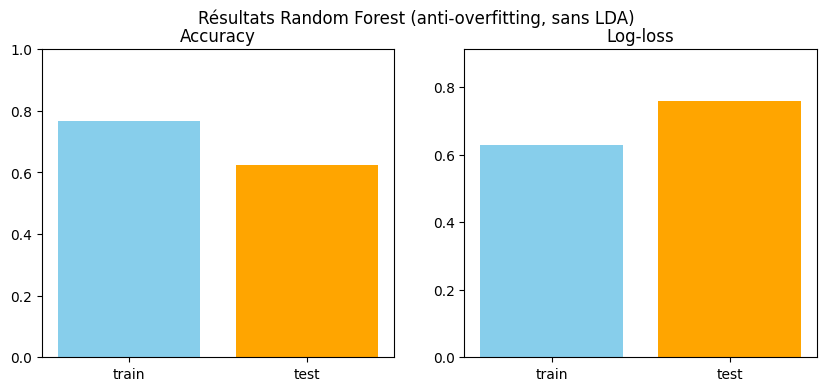

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

# 1. Charger et nettoyer les données
df = pd.read_csv('WineQT.csv')

# Créer la colonne 'bound_sulfur_dioxide'
df['bound_sulfur_dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']

# Supprimer les colonnes inutiles
df_clean = df.drop(['Id', 'total sulfur dioxide'], axis=1)

# Sauvegarder une copie propre
df_clean.to_csv('WineQT_cleaned.csv', index=False)

# Transformation log sur variables très asymétriques
log_vars = ['sulphates', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'bound_sulfur_dioxide']
for var in log_vars:
    df_clean[f'{var}_log'] = np.log1p(df_clean[var])
df_clean = df_clean.drop(log_vars, axis=1)

# Regrouper les labels en 3 catégories
def regrouper_qualite(q):
    if q <= 5:
        return 'faible'
    elif q == 6:
        return 'moyenne'
    else:
        return 'bonne'

df_clean['qualite_cat'] = df_clean['quality'].apply(regrouper_qualite)
X = df_clean.drop(['quality', 'qualite_cat'], axis=1)
y = df_clean['qualite_cat']

# Encoder les labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 2. Pipeline manuel (StandardScaler + RandomForest avec régularisation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

clf.fit(X_train_scaled, y_train)

# 3. Évaluation sur train/test
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)
y_train_proba = clf.predict_proba(X_train_scaled)
y_test_proba = clf.predict_proba(X_test_scaled)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
loss_train = log_loss(y_train, y_train_proba)
loss_test = log_loss(y_test, y_test_proba)

print(f"Accuracy train : {acc_train:.3f} | test : {acc_test:.3f}")
print(f"Log-loss train : {loss_train:.3f} | test : {loss_test:.3f}")

# 4. Validation croisée (accuracy)
cv_scores = cross_val_score(
    clf, scaler.transform(X), y_encoded, cv=5, scoring='accuracy'
)
print(f"Accuracy moyenne (CV 5 folds) : {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# 5. Visualisation
labels = ['train', 'test']
accs = [acc_train, acc_test]
losses = [loss_train, loss_test]

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].bar(labels, accs, color=['skyblue', 'orange'])
ax[0].set_title('Accuracy')
ax[0].set_ylim(0,1)
ax[1].bar(labels, losses, color=['skyblue', 'orange'])
ax[1].set_title('Log-loss')
ax[1].set_ylim(0, max(losses) * 1.2)
plt.suptitle("Résultats Random Forest (anti-overfitting, sans LDA)")
plt.show()


Distribution des classes après SMOTE sur le train :
faible     417
moyenne    417
bonne      417
Name: count, dtype: int64
✅ Accuracy train : 0.948 | test : 0.664
✅ Log-loss train : 0.266 | test : 0.724

=== Classification Report (test) ===
              precision    recall  f1-score   support

       bonne       0.52      0.69      0.59        32
      faible       0.77      0.71      0.74       105
     moyenne       0.61      0.60      0.60        92

    accuracy                           0.66       229
   macro avg       0.64      0.67      0.65       229
weighted avg       0.67      0.66      0.67       229



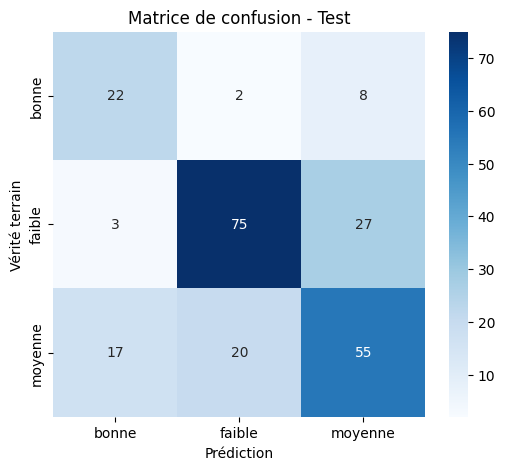

✅ Accuracy moyenne (CV 5 folds) : 0.612 (+/- 0.016)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns

# 1. Charger et nettoyer les données
df = pd.read_csv('WineQT.csv')

# Créer la colonne 'bound_sulfur_dioxide'
df['bound_sulfur_dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']

# Supprimer les colonnes inutiles
df_clean = df.drop(['Id', 'total sulfur dioxide'], axis=1)

# Transformation log sur variables très asymétriques
log_vars = ['sulphates', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'bound_sulfur_dioxide']
for var in log_vars:
    df_clean[f'{var}_log'] = np.log1p(df_clean[var])
df_clean = df_clean.drop(log_vars, axis=1)

# Regrouper les labels en 3 catégories
def regrouper_qualite(q):
    if q <= 5:
        return 'faible'
    elif q == 6:
        return 'moyenne'
    else:
        return 'bonne'

df_clean['qualite_cat'] = df_clean['quality'].apply(regrouper_qualite)
X = df_clean.drop(['quality', 'qualite_cat'], axis=1)
y = df_clean['qualite_cat']

# Encoder les labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Appliquer SMOTE sur le train uniquement
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("Distribution des classes après SMOTE sur le train :")
print(pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts())

# Entraînement XGBoost
clf = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

clf.fit(X_train_bal, y_train_bal)

# Prédictions et probabilités
y_train_pred = clf.predict(X_train_bal)
y_test_pred = clf.predict(X_test_scaled)
y_train_proba = clf.predict_proba(X_train_bal)
y_test_proba = clf.predict_proba(X_test_scaled)

# Évaluation
acc_train = accuracy_score(y_train_bal, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
loss_train = log_loss(y_train_bal, y_train_proba)
loss_test = log_loss(y_test, y_test_proba)

print(f"✅ Accuracy train : {acc_train:.3f} | test : {acc_test:.3f}")
print(f"✅ Log-loss train : {loss_train:.3f} | test : {loss_test:.3f}")

print("\n=== Classification Report (test) ===")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion - Test')
plt.show()

# Validation croisée (sur données non équilibrées, scaler appliqué)
cv_scores = cross_val_score(
    clf, scaler.transform(X), y_encoded, cv=5, scoring='accuracy'
)
print(f"✅ Accuracy moyenne (CV 5 folds) : {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


🔍 Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✅ Meilleurs hyperparamètres : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

✅ Accuracy test : 0.646
✅ Log-loss test : 0.776

=== Classification Report ===
              precision    recall  f1-score   support

       bonne       0.55      0.72      0.62        32
      faible       0.76      0.68      0.72       105
     moyenne       0.57      0.59      0.58        92

    accuracy                           0.65       229
   macro avg       0.63      0.66      0.64       229
weighted avg       0.66      0.65      0.65       229



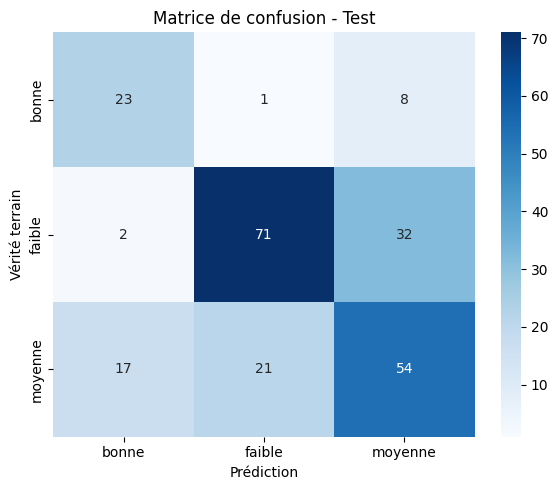

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 1. Charger et nettoyer les données
df = pd.read_csv('WineQT.csv')

# Créer la colonne 'bound_sulfur_dioxide'
df['bound_sulfur_dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']

# Supprimer les colonnes inutiles
df_clean = df.drop(['Id', 'total sulfur dioxide'], axis=1)

# Transformation log sur variables très asymétriques
log_vars = ['sulphates', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'bound_sulfur_dioxide']
for var in log_vars:
    df_clean[f'{var}_log'] = np.log1p(df_clean[var])
df_clean = df_clean.drop(log_vars, axis=1)

# Regrouper les labels en 3 catégories
def regrouper_qualite(q):
    if q <= 5:
        return 'faible'
    elif q == 6:
        return 'moyenne'
    else:
        return 'bonne'

df_clean['qualite_cat'] = df_clean['quality'].apply(regrouper_qualite)
X = df_clean.drop(['quality', 'qualite_cat'], axis=1)
y = df_clean['qualite_cat']

# Encoder les labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE sur le train
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 2. GridSearchCV pour XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

print("🔍 Recherche des meilleurs hyperparamètres...")
grid_search.fit(X_train_bal, y_train_bal)

# Meilleur modèle
best_model = grid_search.best_estimator_
print("\n✅ Meilleurs hyperparamètres :", grid_search.best_params_)

# 3. Évaluation du modèle optimisé
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)

acc_test = accuracy_score(y_test, y_test_pred)
loss_test = log_loss(y_test, y_test_proba)

print(f"\n✅ Accuracy test : {acc_test:.3f}")
print(f"✅ Log-loss test : {loss_test:.3f}")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# 4. Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion - Test')
plt.tight_layout()
plt.show()


✅ Accuracy test : 0.680
✅ Log-loss test : 0.711

=== Classification Report ===
              precision    recall  f1-score   support

       bonne       0.60      0.69      0.64       212
      faible       0.74      0.74      0.74       328
     moyenne       0.68      0.63      0.65       440

    accuracy                           0.68       980
   macro avg       0.67      0.69      0.68       980
weighted avg       0.68      0.68      0.68       980



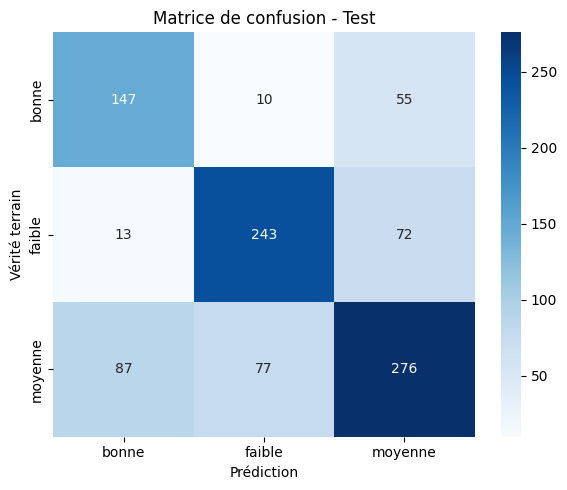

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 1. Charger les données
df = pd.read_csv('winequality-white.csv',sep=';')

# 2. Feature Engineering de base
df['bound_sulfur_dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']
df.drop(['total sulfur dioxide'], axis=1, inplace=True)

# 3. Feature Engineering avancé (interactions)
df['alcohol_volatile'] = df['alcohol'] * df['volatile acidity']
df['citric_fixed_ratio'] = df['citric acid'] / (df['fixed acidity'] + 1e-6)  # éviter division par 0
df['sugar_density_ratio'] = df['residual sugar'] / (df['density'] + 1e-6)
df['sulphates_alcohol'] = df['sulphates'] * df['alcohol']

# 4. Transformation log sur variables très asymétriques
log_vars = ['sulphates', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'bound_sulfur_dioxide']
for var in log_vars:
    df[f'{var}_log'] = np.log1p(df[var])
df.drop(log_vars, axis=1, inplace=True)

# 5. Regrouper les labels en 3 catégories
def regrouper_qualite(q):
    if q <= 5:
        return 'faible'
    elif q == 6:
        return 'moyenne'
    else:
        return 'bonne'

df['qualite_cat'] = df['quality'].apply(regrouper_qualite)

# 6. Séparer features et target
X = df.drop(['quality', 'qualite_cat'], axis=1)
y = df['qualite_cat']

# 7. Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 8. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 9. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 10. SMOTE sur le train
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 11. Entraînement XGBoost avec les meilleurs hyperparamètres précédents
clf = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

clf.fit(X_train_bal, y_train_bal)

# 12. Évaluation
y_test_pred = clf.predict(X_test_scaled)
y_test_proba = clf.predict_proba(X_test_scaled)

acc_test = accuracy_score(y_test, y_test_pred)
loss_test = log_loss(y_test, y_test_proba)

print(f"✅ Accuracy test : {acc_test:.3f}")
print(f"✅ Log-loss test : {loss_test:.3f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# 13. Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion - Test')
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif

# 1. Charger les données
df = pd.read_csv('winequality-white.csv',sep=';')
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


=== Importance des features XGBoost ===
alcohol: 0.2090
volatile acidity: 0.1006
density: 0.0719
residual sugar_log: 0.0619
free sulfur dioxide_log: 0.0596
sugar_density_ratio: 0.0594
chlorides_log: 0.0525
citric acid: 0.0520
bound_sulfur_dioxide_log: 0.0504
fixed acidity: 0.0495
alcohol_volatile: 0.0492
citric_fixed_ratio: 0.0489
pH: 0.0473
sulphates_alcohol: 0.0464
sulphates_log: 0.0415

=== Features sélectionnées ===
['fixed acidity', 'volatile acidity', 'citric acid', 'density', 'alcohol', 'sugar_density_ratio', 'residual sugar_log', 'chlorides_log', 'free sulfur dioxide_log', 'bound_sulfur_dioxide_log']

✅ Accuracy test : 0.647
✅ Log-loss test : 0.753

=== Classification Report ===
              precision    recall  f1-score   support

       bonne       0.54      0.69      0.61       212
      faible       0.72      0.70      0.71       328
     moyenne       0.66      0.59      0.62       440

    accuracy                           0.65       980
   macro avg       0.64      0.

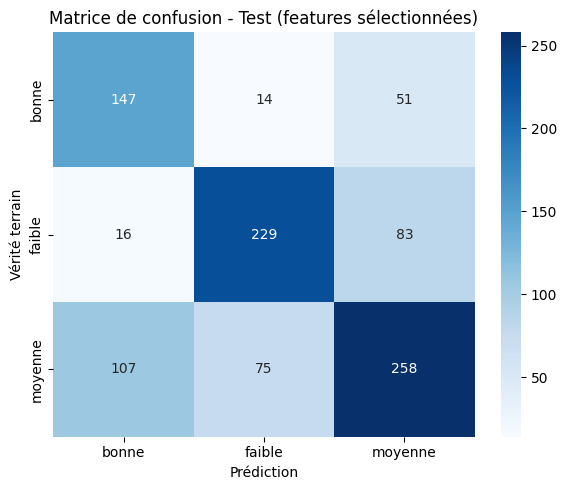

In [7]:

# 2. Feature engineering de base
df['bound_sulfur_dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']
df.drop(['total sulfur dioxide'], axis=1, inplace=True)

# 3. Feature engineering avancé (interactions)
df['alcohol_volatile'] = df['alcohol'] * df['volatile acidity']
df['citric_fixed_ratio'] = df['citric acid'] / (df['fixed acidity'] + 1e-6)
df['sugar_density_ratio'] = df['residual sugar'] / (df['density'] + 1e-6)
df['sulphates_alcohol'] = df['sulphates'] * df['alcohol']

# 4. Transformation log sur variables très asymétriques
log_vars = ['sulphates', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'bound_sulfur_dioxide']
for var in log_vars:
    df[f'{var}_log'] = np.log1p(df[var])
df.drop(log_vars, axis=1, inplace=True)

# 5. Regrouper les labels en 3 catégories
def regrouper_qualite(q):
    if q <= 5:
        return 'faible'
    elif q == 6:
        return 'moyenne'
    else:
        return 'bonne'

df['qualite_cat'] = df['quality'].apply(regrouper_qualite)

# 6. Séparer features et target
X = df.drop(['quality', 'qualite_cat'], axis=1)
y = df['qualite_cat']

# 7. Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 8. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 9. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 10. SMOTE sur le train
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 11. Sélection de features par importance XGBoost
clf_fs = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)
clf_fs.fit(X_train_bal, y_train_bal)

# Importance des features
importances = clf_fs.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

print("\n=== Importance des features XGBoost ===")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

# Sélection automatique (par exemple, garder les 10 plus importantes)
selector = SelectFromModel(clf_fs, prefit=True, max_features=10, threshold=-np.inf)
X_train_sel = selector.transform(X_train_bal)
X_test_sel = selector.transform(X_test_scaled)
selected_features = feature_names[selector.get_support()]

print("\n=== Features sélectionnées ===")
print(list(selected_features))

# (Optionnel) Sélection alternative avec SelectKBest
# kbest = SelectKBest(f_classif, k=10)
# X_train_kbest = kbest.fit_transform(X_train_bal, y_train_bal)
# X_test_kbest = kbest.transform(X_test_scaled)
# print("Features SelectKBest :", list(feature_names[kbest.get_support()]))

# 12. Entraînement XGBoost final sur features sélectionnées
clf = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)
clf.fit(X_train_sel, y_train_bal)

# 13. Évaluation
y_test_pred = clf.predict(X_test_sel)
y_test_proba = clf.predict_proba(X_test_sel)

acc_test = accuracy_score(y_test, y_test_pred)
loss_test = log_loss(y_test, y_test_proba)

print(f"\n✅ Accuracy test : {acc_test:.3f}")
print(f"✅ Log-loss test : {loss_test:.3f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# 14. Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion - Test (features sélectionnées)')
plt.tight_layout()
plt.show()
